# Pre-excerse

Welcome to the jupyter notebook! Before the tensorflow tutorial, how about excersing on jupyter notebook?<br>
So this is the **introduction to jupyter notebook!**

First, you can execute shell commands following by `!`,<br>
otherwise your commands become ipython scripts.<br>
You can *execute* them by `Ctrl+Enter` (or click `Run` buttom at the top bar).<br>
`Ctrl+m l` to show line numbers.

In [ ]:
!pwd

You are using your default shell.

In [ ]:
!echo $SHELL

You can run more complex commands.

In [ ]:
!ls;touch foobar;ls -la foobar

You can edit the inside of the command by clicking. Edit the following incomplete command to remove *foobar* file.

In [ ]:
rmfoobar

While the commands are running, the state become \[\*\]

In [ ]:
!for iii in `seq 10 0`; do sleep 1; echo $iii; done; echo finished!

Actually, you can edit textlines on this notebook by double-clicking.<br>
If you want to insert a *text line*, click `+` bottom and select `Code` to `Markdown`. <br>
After you edit a text line, just `Ctrl+Enter` to replace old lines.

You can also include links and pictures as Markdown format.
![jupyter icon](http://jupyter.org/assets/main-logo.svg)
How about creating [your own jupyter notebook](blank.ipynb)\?

Before processing, check you are using virtualenv python (/XXXXXX/tensorflow-tutorial2018/tensorflow/bin/python).

In [ ]:
!which python

Finally, do not forget you are in *ipython*.

In [215]:
import random
def dice():
    return random.randint(1,6)
print(dice())

1


Let's play with this *dice* function.

[0 0 0 0 0 0]
[187 166 175 158 146 168]


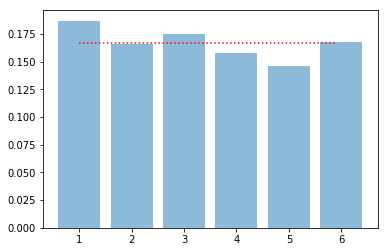

In [219]:
import numpy as np
stat=np.zeros((6,),dtype="int64")  # creating [0,0,0,0,0,0]
print(stat)
N=1000
for i in range(N):
    stat[dice()-1]+=1
print(stat)

# Drawing a graph
!pip install matplotlib
import matplotlib.pyplot as plt
plt.bar(np.arange(1,7),stat/N, alpha=0.5)    # draw a bar graph. alpha for transparency
x = np.arange(1, 6, 0.1)
y = x*0+1./6
plt.plot(x,y, color="red",linestyle="dotted")

Boring graph? Ok, draw a normal distribution.

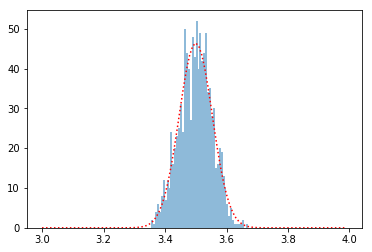

In [218]:
N,M,BINS=1000,1000,50
means=[]
for i in range(N):
    stat=[]
    for j in range(M):
        stat.append(dice())
    means.append(np.mean(stat))
# Drawing a histgram
plt.hist(means, bins=BINS, alpha=0.5) # draw a histgram (unnormalized distribution, or counts per bin) of samples.

# Central limit theorem (中心極限定理)
x = np.arange(3, 4, 0.01)
nu,sigma=3.5,np.sqrt(35/12./M)
y = (1/np.sqrt(2*np.pi*(sigma**2)))*np.exp(-((x-nu)**2/(2*sigma**2))) *((np.max(means)-np.min(means))/BINS*N)
plt.plot(x,y, color="red",linestyle="dotted")

So-called *Matlab-like*!

## Restart ipython

This is a trick to close and re-launch ipython kernel.

In [ ]:
import os; os._exit(00)

# Tensorflow tutorial

Let's enter the tensorflow tutorial.
Run [train.py](http://localhost:8888/edit/train.py).

In [ ]:
!python train.py

## Code reading
Let's see the code of Tensorflow.<br>
(Note: In many tensorflow codes, tensorflow computation graph is defined in a python class, e.g. *class Graph()* in *train.py*. We do not use class for simplicity now.)

Let's define a neural network on ipython.<br>
The neural network consists of two bi-LSTMs and 2-layer MLP for binary classification.<br>
The inputs are word index of pairs of question and answer sentences.<br>
If the question and answer sentence is related, the label is 1, otherwise 0.

In [222]:
import tensorflow as tf
import numpy as np

from data_load import get_batch_data, load_vocab
from hyperparams import Hyperparams as hp
from modules import *

This is a command for reseting tensorflow graph.<br>
If you change your neural network, run the following code and recreate neural network from the first.

In [223]:
tf.reset_default_graph()

First, define placeholders. Placeholders are containers for inputs of the neural network.

In [224]:
idx_q = tf.placeholder(tf.int32, shape=(None, hp.maxlen)) # Question sentence's word index
idx_a = tf.placeholder(tf.int32, shape=(None, hp.maxlen)) # Answer sentence's word index
print(idx_q.shape)
print(idx_a.shape)

(?, 16)
(?, 16)


## Embedding
Change index to embeddings.

In [225]:
vocab_size, num_units=100,40
# Define
lookup_table = tf.get_variable('lookup_table',
                                       dtype=tf.float32,
                                       shape=[vocab_size, num_units],
                                       initializer=tf.contrib.layers.xavier_initializer())
# Lookup
emb_q = tf.nn.embedding_lookup(lookup_table, idx_q)
emb_a = tf.nn.embedding_lookup(lookup_table, idx_a)
print(emb_q.shape)
print(emb_a.shape)

(?, 16, 40)
(?, 16, 40)


I will explain how to initialize *embedding* later.
Let's define LSTMs.

## LSTM
This is a simple rapper function for stacked bi-LSTM layers.<br>
This works for both CPU and GPU.<br>
https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/stack_bidirectional_rnn

This is a cudnn implementation of stacked LSTM. Unfortunately, **this doesn't work on CPU**.

In [226]:
# input shape must be [mini_batch, time_sequence, embedding]
def cudnn_stack_bilstm(input, num_stacked, dim_hidden, timesteps, dropout_rate, name):
    # Define LSTMs
    bilstmA = tf.contrib.cudnn_rnn.CudnnLSTM(num_stacked, dim_hidden, dropout=dropout_rate, name="forward_lstm")
    bilstmB = tf.contrib.cudnn_rnn.CudnnLSTM(num_stacked, dim_hidden, dropout=dropout_rate, name="backward_lstm")
    # Define Computation Graph
    rnninput = tf.transpose(input, perm=[1,0,2])
    rnnoutputA,_ = bilstmA(rnninput)
    rnnoutputB,_ = bilstmB(rnninput[::-1])
    # 各word毎のhidden representationが欲しい時
    rnnoutput = tf.concat([rnnoutputA,rnnoutputB[::-1]],axis=2)
    rnnoutput = tf.transpose(rnnoutput,perm=[1,0,2])
    # 最初と最後のhidden representationを取ってくる
    # rnnoutput_y = tf.concat([rnnoutputA,rnnoutputB],axis=2)[-1] # shape=[timestep, minibatch, emb]
    return rnnoutput

Alternatively, let's use cudnn compagtible lstm for CPU training and test.

In [227]:
# input shape must be [mini_batch, time_sequence, embedding]
def cudnn_cp_stack_bilstm(input, num_stacked, dim_hidden, timesteps, dropout, name):
    # Unstack to expand input to a list of 'timesteps' tensors of shape (mini_batch, embedding)
    input = tf.unstack(input, timesteps, 1)
    # Define lstm cells with tensorflow
    lstm_fw_cell = [tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(dim_hidden, reuse=tf.AUTO_REUSE) for i in range(num_stacked)]
    lstm_bw_cell = [tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(dim_hidden, reuse=tf.AUTO_REUSE) for i in range(num_stacked)]
    # Define computation graph of LSTMs
    outputs, _, _ = tf.contrib.rnn.stack_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, input, dtype=tf.float32)
    # Re-stack at axis of the timesteps.
    outputs=tf.stack(outputs,axis=1)
    return outputs

Let's use *cudnn_cp_stack_bilstm* now.

In [228]:
lstm_units=40
hid_q = cudnn_cp_stack_bilstm(emb_q, 1, lstm_units, hp.maxlen, 0.5, "q")
hid_a = cudnn_cp_stack_bilstm(emb_a, 1, lstm_units, hp.maxlen, 0.5, "a")
print(hid_q.shape)
print(hid_a.shape)

(?, 16, 80)
(?, 16, 80)


The last dimension become twice of LSTM hidden units because of the concatenation of forward and backward LSTMs.
Extract last and forward values of forward and backward LSTMs for a sentence representation.

In [229]:
rep_q = tf.concat([hid_q[:,-1,0:lstm_units+1],hid_q[:,0,lstm_units+1:]], axis=-1)
rep_a = tf.concat([hid_a[:,-1,0:lstm_units+1],hid_a[:,0,lstm_units+1:]], axis=-1)
print(rep_q.shape)
print(rep_a.shape)

(?, 80)
(?, 80)


Concatenate question and answer representation and input to a MLP.

In [230]:
rep = tf.concat([rep_q,rep_q], axis=-1)
hl = tf.layers.dense(rep, hp.hidden_units, activation=tf.nn.relu)
hl = tf.nn.dropout(hl,keep_prob=(0.5))
logits = tf.layers.dense(hl, 2)   # binary classification
prob = tf.nn.softmax(logits)
print(logits.shape)

(?, 2)


Calc loss.

In [231]:
label = tf.placeholder(tf.int32, shape=(None))   # binary class labels
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
mean_loss = tf.reduce_mean(loss)

**Tips:** *sparse_softmax_cross_entropy_with_logits* requires index of labels while *softmax_cross_entropy_with_logits(_v2)* requires distributions of labels.

Define the optimizer.

In [232]:
optimizer = tf.train.AdamOptimizer(learning_rate=hp.lr, beta1=0.9, beta2=0.98, epsilon=1e-8)
train_op = optimizer.minimize(mean_loss)

In [233]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Train your net

Train neural network with very simple datasets.

In [234]:
datasets=[
        [np.array([ [1,4,5,8,3]+[0 for _ in range(11)], [1,1,2,6,3]+[0 for _ in range(11)] ]),
         np.array([ [1,2]+[0 for _ in range(14)],       [9,10]+[0 for _ in range(14)]])],
        [np.array([ [1,4,5,5,3]+[0 for _ in range(11)], [1,4,10,5,3]+[0 for _ in range(11)] ]),
         np.array([ [10]+[0 for _ in range(15)],        [10]+[0 for _ in range(15)]])],
        [np.array([ [4,4,5,6,3]+[0 for _ in range(11)], [9,4,2,6,3]+[0 for _ in range(11)] ]),
         np.array([ [1,2]+[0 for _ in range(14)],       [5,10,4,10]+[0 for _ in range(12)]])],
        [np.array([ [4,4,5,8,3]+[0 for _ in range(11)], [1,4,10,5,3]+[0 for _ in range(11)] ]),
         np.array([ [1,2]+[0 for _ in range(14)],        [1,2]+[0 for _ in range(14)]])],
]
labels=[np.array([0,1]), np.array([1,1]), np.array([0,1]), np.array([0,0])]
print(datasets)
print(labels)
print(label)

for epoch in range(1, 101):
    print("*** Epoch %d ***"%epoch)
    for mb,(data,lab) in enumerate(zip(datasets,labels)):
        feed_dict={
                idx_q:data[0],
                idx_a:data[1],
                label:lab,
                }
        log_loss,log_train_op = sess.run([mean_loss,train_op],feed_dict=feed_dict)
        print("Epoch: %d, Mini-batch: %d, loss: %f"%(epoch,mb,log_loss))
print("Done")

[[array([[1, 4, 5, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 2, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([[ 1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 9, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])], [array([[ 1,  4,  5,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  4, 10,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]), array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])], [array([[4, 4, 5, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [9, 4, 2, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([[ 1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5, 10,  4, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])], [array([[ 4,  4,  5,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  4, 10,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]), array([[1, 2, 0, 0, 

Epoch: 41, Mini-batch: 3, loss: 0.690608
*** Epoch 42 ***
Epoch: 42, Mini-batch: 0, loss: 0.692244
Epoch: 42, Mini-batch: 1, loss: 0.687476
Epoch: 42, Mini-batch: 2, loss: 0.676173
Epoch: 42, Mini-batch: 3, loss: 0.689260
*** Epoch 43 ***
Epoch: 43, Mini-batch: 0, loss: 0.697647
Epoch: 43, Mini-batch: 1, loss: 0.689338
Epoch: 43, Mini-batch: 2, loss: 0.686948
Epoch: 43, Mini-batch: 3, loss: 0.698713
*** Epoch 44 ***
Epoch: 44, Mini-batch: 0, loss: 0.682722
Epoch: 44, Mini-batch: 1, loss: 0.694362
Epoch: 44, Mini-batch: 2, loss: 0.683286
Epoch: 44, Mini-batch: 3, loss: 0.688796
*** Epoch 45 ***
Epoch: 45, Mini-batch: 0, loss: 0.681543
Epoch: 45, Mini-batch: 1, loss: 0.687866
Epoch: 45, Mini-batch: 2, loss: 0.685993
Epoch: 45, Mini-batch: 3, loss: 0.696398
*** Epoch 46 ***
Epoch: 46, Mini-batch: 0, loss: 0.686898
Epoch: 46, Mini-batch: 1, loss: 0.688803
Epoch: 46, Mini-batch: 2, loss: 0.684583
Epoch: 46, Mini-batch: 3, loss: 0.698063
*** Epoch 47 ***
Epoch: 47, Mini-batch: 0, loss: 0.692

Epoch: 91, Mini-batch: 3, loss: 0.699487
*** Epoch 92 ***
Epoch: 92, Mini-batch: 0, loss: 0.696555
Epoch: 92, Mini-batch: 1, loss: 0.664860
Epoch: 92, Mini-batch: 2, loss: 0.655470
Epoch: 92, Mini-batch: 3, loss: 0.708998
*** Epoch 93 ***
Epoch: 93, Mini-batch: 0, loss: 0.694447
Epoch: 93, Mini-batch: 1, loss: 0.674852
Epoch: 93, Mini-batch: 2, loss: 0.673648
Epoch: 93, Mini-batch: 3, loss: 0.686788
*** Epoch 94 ***
Epoch: 94, Mini-batch: 0, loss: 0.692743
Epoch: 94, Mini-batch: 1, loss: 0.694160
Epoch: 94, Mini-batch: 2, loss: 0.662378
Epoch: 94, Mini-batch: 3, loss: 0.706325
*** Epoch 95 ***
Epoch: 95, Mini-batch: 0, loss: 0.685980
Epoch: 95, Mini-batch: 1, loss: 0.672836
Epoch: 95, Mini-batch: 2, loss: 0.686874
Epoch: 95, Mini-batch: 3, loss: 0.713110
*** Epoch 96 ***
Epoch: 96, Mini-batch: 0, loss: 0.669144
Epoch: 96, Mini-batch: 1, loss: 0.684293
Epoch: 96, Mini-batch: 2, loss: 0.658630
Epoch: 96, Mini-batch: 3, loss: 0.699286
*** Epoch 97 ***
Epoch: 97, Mini-batch: 0, loss: 0.683

**Tips:** *sess.run(fetches,feed_dict)* is a function to execute real computations and evaluate (get) tensors specified as *fetches*, given the tensors by *feed_dict*. This can be used for training, testing and other computation operations.

## Test with your net

In [235]:
for data,lab in zip(datasets,labels):
    feed_dict={
            idx_q:data[0],
            idx_a:data[1],
            label:lab,
            }
    log_prob = sess.run([prob],feed_dict=feed_dict)
    log_class = np.argmax(log_prob,axis=-1)
    print("Probability: "+str(log_prob))
    print("Argmax: "+str(log_class))

Probability: [array([[0.48932728, 0.51067275],
       [0.4773536 , 0.5226464 ]], dtype=float32)]
Argmax: [[1 1]]
Probability: [array([[0.50016475, 0.49983525],
       [0.49704963, 0.5029503 ]], dtype=float32)]
Argmax: [[0 1]]
Probability: [array([[0.50519466, 0.49480534],
       [0.4621528 , 0.5378471 ]], dtype=float32)]
Argmax: [[0 1]]
Probability: [array([[0.5000392 , 0.49996075],
       [0.493157  , 0.50684303]], dtype=float32)]
Argmax: [[0 1]]


Actually, this dataset is too tiny to train this network...

## Assign default values to the lookup table.
Use sess.run() after creating a graph.

In [ ]:
# Define lookup table.
embedding_shape=(vocab_size, num_units)
emb_w = tf.Variable(tf.constant(0.0, shape=embedding_shape), name="emb_w")
embedding_placeholder_w = tf.placeholder(tf.float32, embedding_shape)
embedding_init_w = emb_w.assign(embedding_placeholder_w)      # `assign` operation.
# ...
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Run assign computation graph.
init_wmat=np.random.randn(*embedding_shape)                   # Of course, you can swap this with gensim vec. 
sess.run([embedding_init_w], feed_dict={embedding_placeholder_w: init_wmat})

## Tensorboard

This is a special line for tensorboard. You don't need to run below.

In [ ]:
tf.summary.FileWriter(logdir='./graph/', graph=tf.Graph())

In [ ]:
!tensorboard --logdir='./graph/'

Access localhost:PORT_NUM

### Tips
This is the BasicLSTM of Tensorflow. You might see in many websites introducing tensorflow.<br>
However, experts rarely use this.

In [ ]:
# input shape must be [mini_batch, time_sequence, embedding]
def simple_stack_bilstm(input, num_stacked, dim_hidden, timesteps, dropout, name):
   # Unstack to expand input to a list of 'timesteps' tensors of shape (mini_batch, embedding)
    input = tf.unstack(input, timesteps, 1)
    # Define lstm cells with tensorflow
    lstm_fw_cell = [tf.contrib.rnn.BasicLSTMCell(dim_hidden, forget_bias=1.0, reuse=tf.AUTO_REUSE, name=name+"_f_"+str(i)) for i in range(num_stacked)]
    lstm_bw_cell = [tf.contrib.rnn.BasicLSTMCell(dim_hidden, forget_bias=1.0, reuse=tf.AUTO_REUSE, name=name+"_b_"+str(i)) for i in range(num_stacked)]
    # Define computation graph of LSTMs
    outputs, _, _ = tf.contrib.rnn.stack_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, input, dtype=tf.float32)
    outputs=tf.stack(outputs,axis=1)
    return outputs